# VAMP Workflow Tutorial

This notebook demonstrates how to use `geom2vec.models.downstream.vamp.VAMPWorkflow` to
train a VAMPNet on precomputed geom2vec embeddings and extract collective variables (CVs).

In [1]:
from pathlib import Path

import torch

from geom2vec.models.downstream import Lobe, VAMPWorkflow
from geom2vec.models.downstream.vamp.vampnet import VAMPNetConfig


/project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/libpyg.so)
  import torch_geometric.typing
/project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /project/dinner/zpengmei/conda_envs/openmm/lib/python3.12/site-packages/libpyg.so)
  import torch_geometric.typing


## Load Precomputed Embeddings

Point `embedding_dir` to the folder produced by the inference notebook (e.g.
`4_infer_mdanalysis.ipynb`). Each `.pt` file should contain a tensor of shape
`(num_frames, 4, hidden_channels)`.

In [2]:
embedding_dir = Path("/project/dinner/zpengmei/geom2vec_02/examples/_artifacts/chignolin_infer")
lag_time = 1
train_fraction = 0.8  # fraction of data used for training when multiple trajectories exist

paths = sorted(embedding_dir.glob('*.pt'))
if not paths:
    raise FileNotFoundError(f'No embeddings found in {embedding_dir}. Run the inference notebook first.')

raw_trajectories = [torch.load(path) for path in paths]
trajectories = []
for tensor in raw_trajectories:
    if tensor.dim() == 3:
        tensor = tensor.unsqueeze(1)  # add token dimension
    trajectories.append(tensor)

print(f'Loaded {len(trajectories)} trajectories with shapes: {[traj.shape for traj in trajectories]}')


/scratch/local/jobs/42899410/ipykernel_343551/2023193806.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_trajectories = [torch.load(path) for path in paths]


Loaded 54 trajectories with shapes: [torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), torch.Size([1000, 10, 4, 128]), tor

## Configure the VAMP Lobe

We build a simple `Lobe` head that mixes scalar/vector features from the geom2vec representations.

In [10]:
hidden_channels = trajectories[0].shape[-1]
num_tokens = trajectories[0].shape[1]

lobe = Lobe(
    input_channels=hidden_channels,
    hidden_channels=hidden_channels,
    output_channels=3,
    num_mlp_layers=2,
    num_tokens=num_tokens,
    equi_rep=True,
    merger=False,
    merger_window=2,
    equi_backend='triton'
).cuda()
lobe


Lobe(
  (dropout): Dropout(p=0.0, inplace=False)
  (input_projection): EquiLinear(
    (scalar_linear): Linear(in_features=128, out_features=128, bias=True)
    (vector_linear): Linear(in_features=128, out_features=128, bias=False)
  )
  (gnn_layer): EquivariantGraphConv(
    (lin_scalar_rel): Linear(in_features=128, out_features=128, bias=False)
    (lin_scalar_root): Linear(in_features=128, out_features=128, bias=True)
    (lin_vector_rel): Linear(in_features=384, out_features=384, bias=False)
    (lin_vector_root): Linear(in_features=384, out_features=384, bias=False)
  )
  (pos_encoding): PositionalEncoding()
  (mixer): ModuleList(
    (0-3): 4 x EquivariantAttentionBlock(
      (attention): EquivariantSelfAttentionTriton(
        (q_proj): Linear(in_features=128, out_features=128, bias=True)
        (k_proj): Linear(in_features=128, out_features=128, bias=True)
        (v_proj): Linear(in_features=128, out_features=128, bias=True)
        (o_proj): Linear(in_features=128, out_feat

## Build the Workflow

`VAMPWorkflow` handles dataset construction, splitting, and training orchestration.
Set `concat_trajectories=True` if your embeddings come from contiguous segments that
should be stitched together before performing time-based splits.

In [12]:
config = VAMPNetConfig(
    device='cuda',  # change to 'cuda' once FlashAttention kernels are available
    train_patience=20,
    valid_patience=20,
    train_valid_interval=20,
    learning_rate=1e-4,
    score_method='vamp-2',
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

workflow = VAMPWorkflow(
    lobe=lobe.to(device),
    trajectories=trajectories,
    lag_time=lag_time,
    config=config,
    train_fraction=train_fraction,
    batch_size=1000,
    seed=0,
    concat_trajectories=True,
)
workflow


## Train the VAMPNet

Use `fit` to optimize the lobe(s). Progress bars can be disabled by providing a dummy progress function.

In [14]:
vamp = workflow.fit(n_epochs=5, progress=lambda iterable, **_: iterable)
print('Training batches:', len(workflow.train_loader))


best val: -inf: 0it [00:00, ?it/s]

Training batches: 43


## Extract Collective Variables

After training, obtain CVs for the training split (or provide new data).

In [15]:
train_cvs = workflow.get_cvs(split="train")
print(f'Collected {len(train_cvs)} trajectories of CVs.')
print('First trajectory shape:', train_cvs[0].shape)


Collected 42779 trajectories of CVs.
First trajectory shape: (3,)


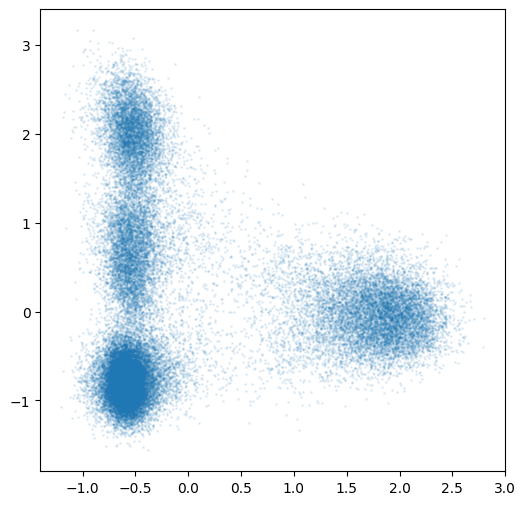

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(train_cvs[:,0], train_cvs[:,1], s=1, alpha=0.1)